In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from scipy import interpolate
from time import sleep
from tqdm import tqdm
from scipy.signal import stft
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
def Cumulative(wave):
    cu_list = []
    lists = wave.tolist()[0]
    length = len(lists)
    lists = [i**2 for i in lists]
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return np.array(cu_list[1:])

def FindValueIndex(seq, val):
    r = np.where(np.diff(np.sign(seq - val)) != 0)
    idx = r + (val - seq[r]) / (seq[r + np.ones_like(r)] - seq[r])
    idx = np.append(idx, np.where(seq == val))
    idx = np.sort(idx)
    return np.round(idx)

def FindTOF(wave):
  Ts = 2e-7
  Threshold = 0.25
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Time_response[index]) if val > 145e-6)

  return TOF*1e6

def FindTOF_longwindow(wave):
  Ts = 2e-7
  Threshold = 0.25
  Long_response = np.arange(145e-6, 225e-6+Ts/2, Ts)
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Long_response[index]) if val > 154e-6)
  return TOF*1e6

# GenerateSine(Peak-peak Amplitude,frequency,cycles)
def GenerateSine(A,freq,cycles):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  return Amp

def GenerateNoisySine(A,freq,cycles,sigma):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  noise_sigma = np.std(Amp)*sigma
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  Amp = Amp + np.random.normal(0,noise_sigma,len(Amp))
  return Amp

# consider the specific heat ratio
def Cal_percentage(t_A,M_B,delta_t,gas):
    if gas == 'Air':
      k_B = 1.4 # air
    elif gas == 'Argon':
      k_B = 1.66 # argon
    M_A =  4.002602 #  Gas A: helium [g/mol]
    k_A = 1.66
    M_ratio = (M_B-M_A)/M_A
    t_ratio = (t_A/(t_A+delta_t))**2
    nume = k_A * (1-t_ratio)
    denu = t_ratio*k_A*M_ratio-k_B+k_A
    percentage = nume/denu # percentage (minus means delay)
    return percentage*100

def Cal_deltaTOF(con_argon,con_air):

    R = 8.314 # individual gas constant (J/mol*K)
    T = 292 # absolute temperature (K)
    L = 150 # [mm]
    t_A = L / np.sqrt(1.66*R*T/(4.002602/1e3)) * 1e3
    k_M = (1.66*(100-con_argon-con_air)+1.66*con_argon+1.4*con_air)/100
    M_M = (4.002602*(100-con_argon-con_air)+39.948*con_argon+28.966*con_air)/100/1e3 # kg/mol
    c_M = np.sqrt(k_M*R*T/M_M)
    return (L / c_M * 1e3-t_A)

def Cal_deltaTOF_T(con_argon,con_air,T_initial,T_impurity):

    R = 8.314 # individual gas constant (J/mol*K)
    L = 150 # [mm]
    t_A = L / np.sqrt(1.66*R*T_initial/(4.002602/1e3)) * 1e3
    k_M = (1.66*(100-con_argon-con_air)+1.66*con_argon+1.4*con_air)/100
    M_M = (4.002602*(100-con_argon-con_air)+39.948*con_argon+28.966*con_air)/100/1e3 # kg/mol
    c_M = np.sqrt(k_M*R*T_impurity/M_M)
    return (L / c_M * 1e3-t_A)

def CalVolume(array,time,gas):
    MFC_Helium = 0.1646 #(sl/s) / V
    MFC_Air = 118.56  #(sccm/s) / V

    interval = time / len(array)
    if gas == 'Helium':
        volume = np.trapz(array * MFC_Helium, dx=interval)
    elif gas == 'Air':
        volume = np.trapz(array * MFC_Air, dx=interval)
    return(volume)

def compute_normalized_stft(signal, fs, window_size, overlap, max_frequency):
    frequencies, times, Zxx = stft(signal, fs=fs, window='hann', nperseg=window_size, noverlap=overlap)
    magnitude = np.abs(Zxx)

    max_freq_idx = np.argmax(frequencies > max_frequency)
    magnitude = magnitude[:max_freq_idx, :]

    magnitude_db = 20 * np.log10(np.maximum(magnitude, 1e-8))

    return magnitude_db

def find_closest_con_air(con_argon, delta_TOF_truth):
    con_air_range = np.linspace(0, 1.2, 500)
    delta_TOFs = [Cal_deltaTOF(con_argon, con_air) for con_air in con_air_range]
    idx = np.argmin(np.abs(np.array(delta_TOFs) - delta_TOF_truth))
    return con_air_range[idx]

# Data Pre-processing

Read Excitations

In [ ]:
Excitation_set = []

In [ ]:
Ts = 2e-7
Time_exci = np.arange(0, 85e-6+Ts/2, Ts)
Time_exci

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/500khz

for n in range(275):
  x = np.loadtxt('C1--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]))
  t_end = np.argmin(abs(x[:,0]-50e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Excitation = interpolator(Time_exci)

  Excitation_set.append(list(Interpolated_Excitation))

/content/gdrive/.shortcut-targets-by-id/194AAoMald4Ypsq8mZ7vYTSA-BHCW4Wdm/AME508/Helium-Data/Training_data_pure_helium/500khz


In [ ]:
Excitation_set = np.array(Excitation_set)

In [ ]:
np.save('Excitation_set.npy',Excitation_set)

In [ ]:
test = GenerateSine(0.4,500,10)

(0.0, 50.0)

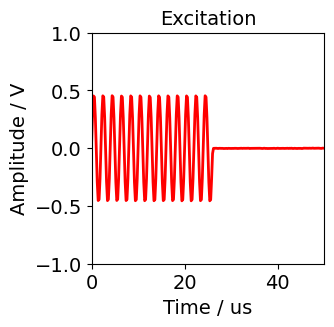

In [27]:
from matplotlib import rcParams
plt.figure(figsize=(3,3),dpi=100)  # Figure size
mpl.rcParams.update({'font.size': 14})  # Global font size

idx = 5249

Time_plot = np.arange(0, 85e-6+Ts/2, Ts)
plt.plot(Time_plot*1e6,Response_test[idx:idx+1,426:].reshape(-1,1),linewidth=2,color='red')
#plt.plot(Time_exci*1e6,test.reshape(-1,1),linewidth=2,color='b')

plt.title('Excitation',fontsize=14)
plt.xlabel ('Time / us')
plt.ylabel ('Amplitude / V')
plt.ylim(-1,1)
plt.xlim(0,50)

Read Responses

In [ ]:
Response_set = []

In [ ]:
Time_response = np.arange(145e-6, 230e-6+Ts/2, Ts)


In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/600khz

for n in range(228):
  x = np.loadtxt('C2--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")

  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-215e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Response = interpolator(Time_response)

  Response_set.append(list(Interpolated_Response))

/content/gdrive/.shortcut-targets-by-id/194AAoMald4Ypsq8mZ7vYTSA-BHCW4Wdm/AME508/Helium-Data/Training_data_pure_helium/600khz


In [ ]:
Response_set = np.array(Response_set)

In [ ]:
np.save('Response_set.npy',Response_set)

(-1.0, 1.0)

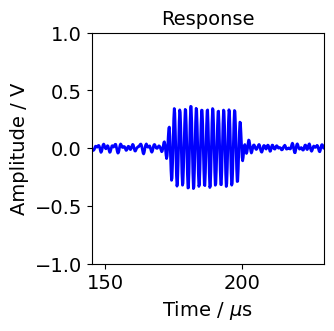

In [28]:
plt.figure(figsize=(3,3),dpi=100)  # Figure size
mpl.rcParams.update({'font.size': 14})  # Global font size

plt.plot(Time_response*1e6,Response_test[idx:idx+1,:426].reshape(-1,1),linewidth=2,color='b')
plt.xlabel (r"Time / $\it{\mu}$s"),plt.xlim(145,230)
plt.ylabel ('Amplitude / V')
plt.title('Response',fontsize=14)
plt.ylim(-1,1)

# Load Pre-processed Data (Please RUN FROM HERE)

In [4]:
%cd /content/gdrive/MyDrive/AME508/Low-Impurity

/content/gdrive/MyDrive/AME508/Low-Impurity


In [5]:
Excitation_set = np.load('Input_set.npy') # 2351 is the # of samples, 251 is the length
Response_set = np.load('Response_set.npy') # 426 is the length
Concen_set = np.load('Concen_set.npy')
Image_train = np.load('Image_train.npy')
Image_test = np.load('Image_test.npy')

Ts = 2e-7 # sampling interval
Time_exci = np.arange(0, 50e-6+Ts/2, Ts)
Time_response = np.arange(145e-6, 230e-6+Ts/2, Ts)

In [6]:
# REMOVE <100mVpp
idx_to_delet = np.argwhere(np.ptp(Response_set, axis=1) < 0.2)
#idx_to_delet = np.argwhere(np.ptp(Excitation_set[:,:-2], axis=1) < 0.1)
Excitation_set = np.delete(Excitation_set,idx_to_delet,axis=0)
Response_set = np.delete(Response_set,idx_to_delet,axis=0)
Concen_set = np.delete(Concen_set,idx_to_delet,axis=0)

In [7]:
# REMOVE those random shift by equipment
idx_to_delet = np.argwhere(Excitation_set[:,0]>0.1)
Excitation_set = np.delete(Excitation_set,idx_to_delet,axis=0)
Response_set = np.delete(Response_set,idx_to_delet,axis=0)
Concen_set = np.delete(Concen_set,idx_to_delet,axis=0)

In [8]:
Ex_set_zeropad = np.pad(Excitation_set[:,:-2], ((0,0),(0,175)), 'constant')
X = np.column_stack((Response_set,Ex_set_zeropad,Concen_set))

Response_train, Response_test, Concen_train, Concen_test = train_test_split(X[:,:426*2], X[:,-2:], test_size = 0.3,random_state=42)
train_input = Response_train
train_truth = Concen_train

X_train = np.column_stack((train_input,train_truth))

np.shape(X_train)

(65011, 854)

In [9]:
sampling_rate = 5e6 # 5 MHz
window_size = 185
overlap = 175
max_frequency = 1e6

num_samples = Response_train.shape[0]
Image_train = []

for i in range(num_samples):
    response_spectrum = compute_normalized_stft(Response_train[i,:426], sampling_rate, window_size, overlap, max_frequency)
    excitation_spectrum = compute_normalized_stft(Response_train[i,426:], sampling_rate, window_size, overlap, max_frequency)

    combined_spectrum = np.stack((response_spectrum, excitation_spectrum), axis=-1)
    Image_train.append(combined_spectrum)

Image_train = np.array(Image_train)
print(Image_train.shape)

(65011, 38, 44, 2)


In [10]:
num_samples = Response_test.shape[0]
Image_test = []

for i in range(num_samples):
    response_spectrum = compute_normalized_stft(Response_test[i,:426], sampling_rate, window_size, overlap, max_frequency)
    excitation_spectrum = compute_normalized_stft(Response_test[i,426:], sampling_rate, window_size, overlap, max_frequency)

    combined_spectrum = np.stack((response_spectrum, excitation_spectrum), axis=-1)
    Image_test.append(combined_spectrum)

Image_test = np.array(Image_test)
print(Image_test.shape)

(27862, 38, 44, 2)


In [ ]:
# Save Image_train as a .npy file
np.save('Image_train.npy', Image_train)

# Save Image_test as a .npy file
np.save('Image_test.npy', Image_test)

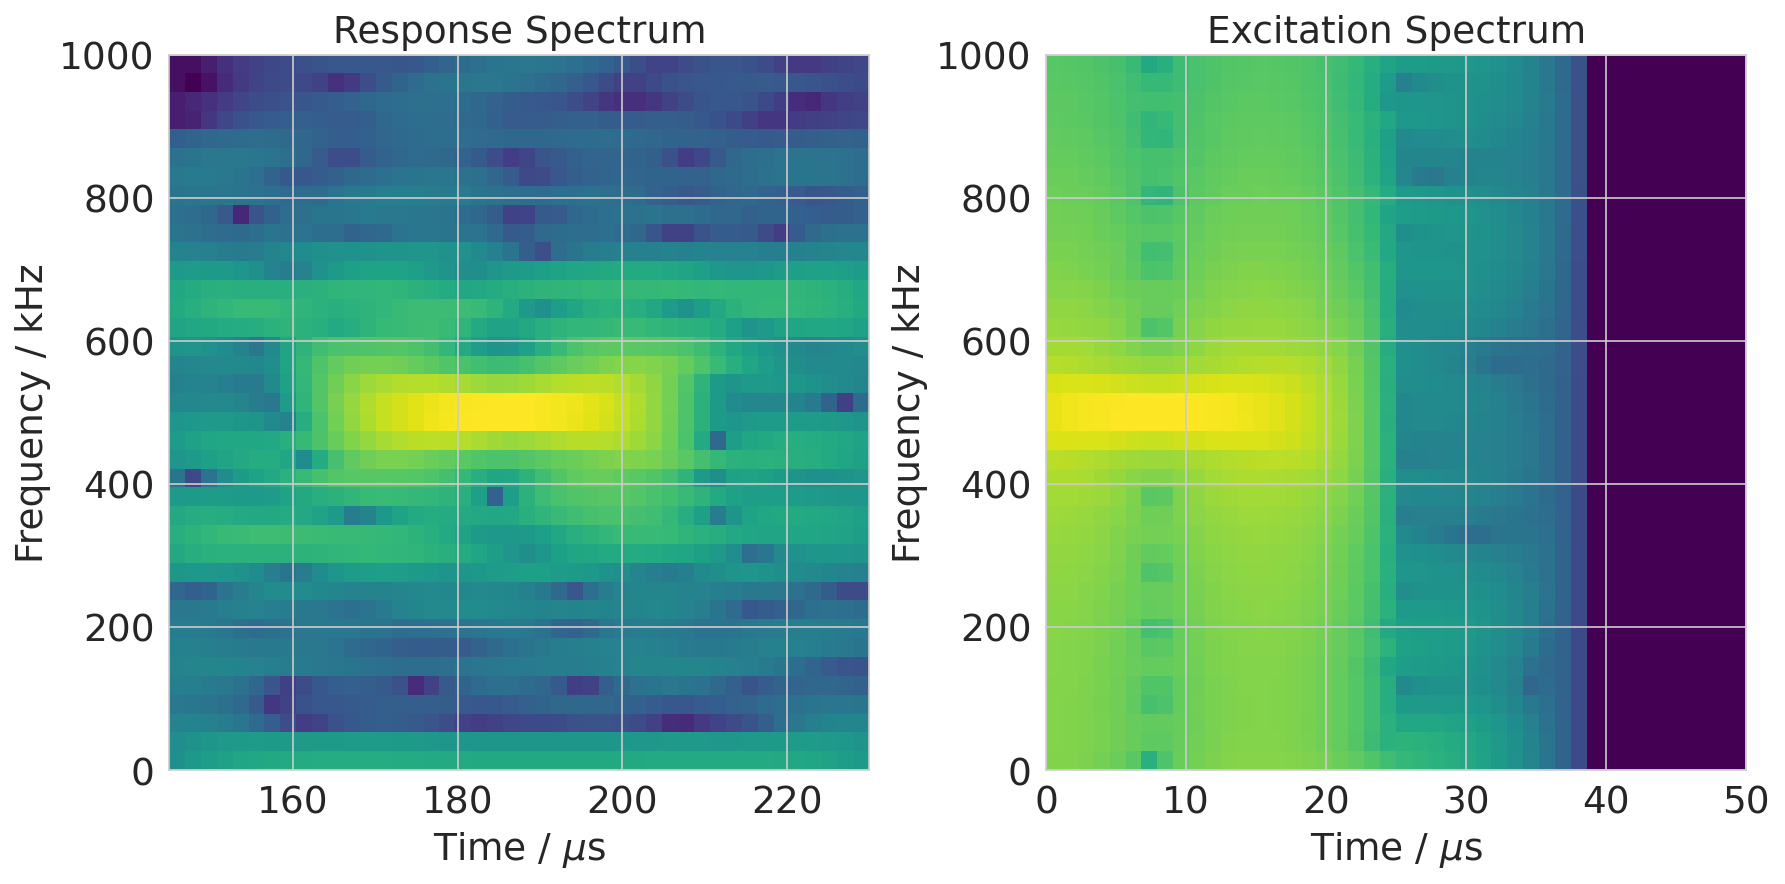

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6),dpi=150)

sample_idx = 5249

response_spectrum = Image_test[sample_idx, :, :, 0]
excitation_spectrum = Image_test[sample_idx, :, :, 1]

ax1.imshow(response_spectrum, aspect='auto', origin='lower', cmap='viridis', extent=[145, 230, 0, 1e3])
ax1.set_title('Response Spectrum',fontsize=18)
ax1.set_xlabel(r"Time / $\it{\mu}$s",fontsize=18)
ax1.set_ylabel('Frequency / kHz',fontsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

ax2.imshow(excitation_spectrum, aspect='auto', origin='lower', cmap='viridis', extent=[0, 50, 0, 1e3])
ax2.set_title('Excitation Spectrum',fontsize=18)
ax2.set_xlabel(r"Time / $\it{\mu}$s",fontsize=18)
ax2.set_ylabel('Frequency / kHz',fontsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.show()

# Create custom dataset class

In [11]:
class CombinedDataSet(torch.utils.data.Dataset):
    def __init__(self, time_data, image_data, labels):
        self.time_data = time_data
        self.image_data = image_data
        self.labels = labels

    def __len__(self):
        return len(self.time_data)

    def __getitem__(self, idx):
        return self.time_data[idx], self.image_data[idx], self.labels[idx]

# Build and Train Neural Network

In [12]:
import torch.nn.functional as F

class CNNcoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(2, 4, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv1d(4, 8, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=0)

        self.fc1 = nn.Linear(16 * 6, 32)
        self.fc2 = nn.Linear(32, 2)

        self.pool = nn.MaxPool1d(2, stride=2)

        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        self.act = nn.ReLU()

        x = self.pool(self.act(self.conv1(x)))

        x = self.pool(self.act(self.conv2(x)))
        x = self.dropout(x)

        x = self.pool(self.act(self.conv3(x)))

        x = torch.flatten(x, 1)

        x = self.act(self.fc1(x))
        x = self.dropout(x)

        x = self.act(self.fc2(x))

        return x

In [13]:
import torch.nn.functional as F

class CNN_STFT(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(2, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(16 * 4 * 5, 32)
        self.fc2 = nn.Linear(32, 2)

        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        self.act = nn.ReLU()

        x = self.pool(self.act(self.conv1(x)))

        x = self.pool(self.act(self.conv2(x)))
        x = self.dropout(x)

        x = self.pool(self.act(self.conv3(x)))

        x = torch.flatten(x, 1)

        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))

        return x

In [14]:
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.linear_combination1 = nn.Linear(2, 1)
        self.linear_combination2 = nn.Linear(2, 1)

    def forward(self, x, image_data):
        self.act = nn.ReLU()
        out1 = self.model1(x)
        out2 = self.model2(image_data)

        combined_output1 = torch.cat((out1[:, :1], out2[:, :1]), dim=1)
        output1 = self.linear_combination1(combined_output1)

        combined_output2 = torch.cat((out1[:, 1:], out2[:, 1:]), dim=1)
        output2 = self.linear_combination2(combined_output2)

        output = self.act(torch.cat((output1, output2), dim=1))
        return output

In [ ]:
def count_trainable_params(model):
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = torch.prod(torch.tensor(param.size())).item()
            total_params += num_params
            print(name, param.size())
    return total_params

model = CNNcoder()
total_trainable_params = count_trainable_params(model)
print("Total number of trainable parameters:", total_trainable_params)

conv1.weight torch.Size([4, 2, 3])
conv1.bias torch.Size([4])
conv2.weight torch.Size([8, 4, 3])
conv2.bias torch.Size([8])
conv3.weight torch.Size([16, 8, 3])
conv3.bias torch.Size([16])
fc1.weight torch.Size([32, 96])
fc1.bias torch.Size([32])
fc2.weight torch.Size([2, 32])
fc2.bias torch.Size([2])
Total number of trainable parameters: 3702


In [ ]:
from torchsummary import summary
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

summary(CNNcoder().to(device),input_size=(2,426))
#summary(CNN_STFT().to(device),input_size=(2,38,44))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 212]              28
         MaxPool1d-2               [-1, 4, 106]               0
            Conv1d-3                [-1, 8, 52]             104
         MaxPool1d-4                [-1, 8, 26]               0
            Conv1d-5               [-1, 16, 12]             400
         MaxPool1d-6                [-1, 16, 6]               0
            Linear-7                   [-1, 32]           3,104
            Linear-8                    [-1, 2]              66
Total params: 3,702
Trainable params: 3,702
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


# Training

In [15]:
batch_size = 640
combined_data = CombinedDataSet(X_train, Image_train, Concen_train)
training_generator_combined = torch.utils.data.DataLoader(combined_data, batch_size=batch_size, shuffle=True)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cnn = CNNcoder().to(device)
cnn_stft = CNN_STFT().to(device)
ensemble_model = EnsembleModel(cnn, cnn_stft).to(device)

loss_fn = nn.MSELoss()
max_epochs = 200

optimizer = optim.AdamW(ensemble_model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

train_loss = []
test_loss = []
test_batch_size = 5000  # or any smaller value

groundtruth_test = torch.from_numpy(Concen_test).to(torch.float32).to(device)
num_test_batches = len(groundtruth_test) // test_batch_size
groundtruth_test_batches = torch.split(groundtruth_test[:num_test_batches * test_batch_size], test_batch_size)
groundtruth_test_batches += (groundtruth_test[num_test_batches * test_batch_size:],)

for epoch in tqdm(range(max_epochs)):
    for index, (data, image_data, labels) in enumerate(training_generator_combined):
        inputs_train = data[:,:852].to(torch.float32).to(device)
        inputs_train = torch.reshape(inputs_train, (inputs_train.size(dim=0), 2, 426))
        groundtruth_train = labels.reshape(-1,1).to(torch.float32).to(device)

        inputs_train_image = torch.reshape(image_data, (image_data.size(dim=0), 2, image_data.shape[1], image_data.shape[2])).to(torch.float32).to(device)

        optimizer.zero_grad()

        prediction = ensemble_model(inputs_train, inputs_train_image).reshape(-1,1)

        train_loss_i = loss_fn(prediction, groundtruth_train)

        train_loss_i.backward()

        optimizer.step()

    train_loss.append(train_loss_i.item())

    inputs_test = torch.from_numpy(Response_test).to(torch.float32).to(device)
    inputs_test = torch.reshape(inputs_test, (inputs_test.size(dim=0), 2, 426))
    inputs_test_image = torch.from_numpy(Image_test).to(torch.float32).to(device).reshape(-1, 2, Image_test.shape[1], Image_test.shape[2])

    # Split the test data into smaller batches
    inputs_test_batches = torch.split(inputs_test, test_batch_size)
    inputs_test_image_batches = torch.split(inputs_test_image, test_batch_size)
    groundtruth_test_batches = torch.split(groundtruth_test, test_batch_size)

    # Evaluate the model on smaller batches
    test_loss_epoch = []
    for inputs_test_batch, inputs_test_image_batch, groundtruth_test_batch in zip(inputs_test_batches[:-1], inputs_test_image_batches[:-1], groundtruth_test_batches[:-1]):
      test_predi = ensemble_model(inputs_test_batch, inputs_test_image_batch).reshape(groundtruth_test_batch.shape)
      test_loss_i = loss_fn(test_predi, groundtruth_test_batch).cpu().detach().numpy()
      test_loss_epoch.append(test_loss_i)

    # Handle the last batch separately
    inputs_test_batch = inputs_test_batches[-1]
    inputs_test_image_batch = inputs_test_image_batches[-1]
    groundtruth_test_batch = groundtruth_test_batches[-1]

    test_predi = ensemble_model(inputs_test_batch, inputs_test_image_batch)[:groundtruth_test_batch.shape[0], :].reshape(groundtruth_test_batch.shape)
    test_loss_i = loss_fn(test_predi, groundtruth_test_batch).cpu().detach().numpy()
    test_loss_epoch.append(test_loss_i)

    # Aggregate the results
    test_loss_i = np.mean(test_loss_epoch)
    scheduler.step(test_loss_i)

    test_loss.append(test_loss_i)
    print(f'The test loss: {test_loss_i}')
    sleep(0)

In [ ]:
PATH_1 = './Ensemble-wave-0.1-dropout.pth'
torch.save(cnn.state_dict(), PATH_1)

PATH_2 = './Ensemble-STFT-0.1-dropout.pth'
torch.save(cnn_stft.state_dict(), PATH_2)

PATH_3 = './Ensemble-wave+STFT-0.1-dropout.pth'
torch.save(ensemble_model.state_dict(), PATH_3)

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

PATH_1 = './Ensemble-wave-0.1-dropout.pth'
PATH_2 = './Ensemble-STFT-0.1-dropout.pth'
PATH_3 = './Ensemble-wave+STFT-0.1-dropout.pth'

# create the model
cnn = CNNcoder().to(device)
cnn_stft = CNN_STFT().to(device)
ensemble_model = EnsembleModel(cnn, cnn_stft).to(device)

cnn.load_state_dict(torch.load(PATH_1,map_location=torch.device('cpu')))
cnn_stft.load_state_dict(torch.load(PATH_2,map_location=torch.device('cpu')))
ensemble_model.load_state_dict(torch.load(PATH_3,map_location=torch.device('cpu')))

cpu


<All keys matched successfully>

# Visualization

In [ ]:
print(train_loss[-1])
print(test_loss[-1])

0.04243136942386627
0.04282196


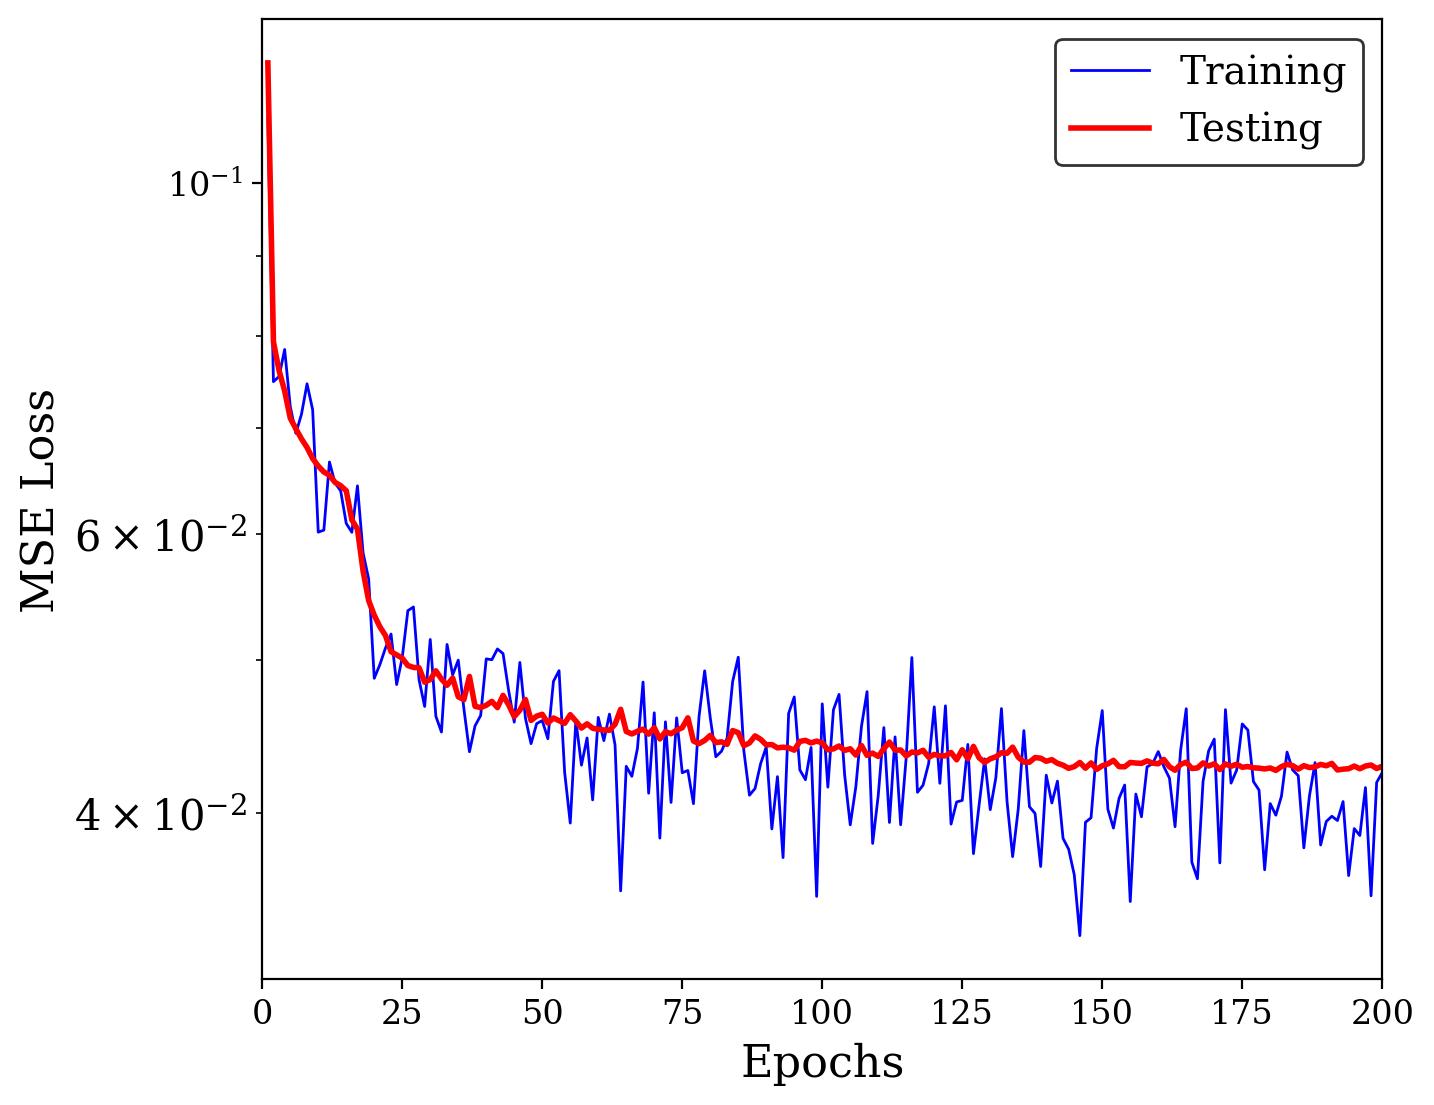

In [ ]:
nc = 1; nr = 1;
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,6*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.5)

epoNum = np.arange(1,max_epochs+1)
plt.plot(epoNum,train_loss,'-b',linewidth = 1,label='Training')
#plt.plot(epoNum,vali_loss,'-k',linewidth = 2,label='Validation')
plt.plot(epoNum,test_loss,'-r',linewidth = 2,label='Testing')

ax.legend(loc='upper right',edgecolor='k',fontsize=14,frameon=True,ncol=1)
ax.set_xlabel('Epochs',fontsize=16)
ax.set_ylabel('MSE Loss',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([0, max_epochs])
#ax.set_ylim([0, 10])
plt.yscale('log')
plt.rcdefaults()

In [ ]:
# plot the output vs ground truth

In [ ]:
loss_list = []

inputs_train = torch.from_numpy(Response_train).to(torch.float32).to(device)
inputs_train = torch.reshape(inputs_train, (inputs_train.size(dim=0), 2, 426))

groundtruth_train = torch.from_numpy(Concen_train).to(torch.float32).to(device)
groundtruth_train = groundtruth_train.reshape(-1,1)

inputs_train_image = torch.from_numpy(Image_train).to(torch.float32).to(device)
inputs_train_image = torch.reshape(inputs_train_image, (inputs_train_image.size(dim=0), 2, Image_train.shape[1], Image_train.shape[2]))

for run in range(10):
    with torch.no_grad():
        # Forward pass
        prediction = ensemble_model(inputs_train, inputs_train_image).reshape(-1,1)

        # Compute loss
        train_loss = loss_fn(prediction, groundtruth_train)

        loss_list.append(train_loss.item())

# Calculate mean and standard deviation of the losses
loss_mean = np.mean(loss_list)
loss_std = np.std(loss_list)

# Print average training loss and the standard deviation
print('Mean training loss: ', loss_mean)
print('Standard deviation of training loss: ', loss_std)

Mean training loss:  0.0403441708534956
Standard deviation of training loss:  7.175427937433125e-05


In [ ]:
test_loss_list = []

inputs_test = torch.from_numpy(Response_test).to(torch.float32).to(device)
inputs_test = torch.reshape(inputs_test, (inputs_test.size(dim=0), 2, 426))

groundtruth_test = torch.from_numpy(Concen_test).to(torch.float32).to(device)
groundtruth_test = groundtruth_test.reshape(-1,1)

inputs_test_image = torch.from_numpy(Image_test).to(torch.float32).to(device)
inputs_test_image = torch.reshape(inputs_test_image, (inputs_test_image.size(dim=0), 2, Image_test.shape[1], Image_test.shape[2]))

for run in range(10):
    with torch.no_grad():
        # Forward pass
        test_predi = ensemble_model(inputs_test, inputs_test_image).reshape(-1,1)

        # Compute loss
        test_loss = loss_fn(test_predi, groundtruth_test).cpu().numpy()

        test_loss_list.append(test_loss.item())

# Calculate mean and standard deviation of the losses
test_loss_mean = np.mean(test_loss_list)
test_loss_std = np.std(test_loss_list)

# Print average test loss and the standard deviation
print('Mean test loss: ', test_loss_mean)
print('Standard deviation of test loss: ', test_loss_std)

Mean test loss:  0.04279499240219593
Standard deviation of test loss:  0.00010591309217046486


In [ ]:
test_predi_list = []

inputs_test = torch.from_numpy(Response_test).to(torch.float32).to(device)
inputs_test = torch.reshape(inputs_test, (inputs_test.size(dim=0), 2, 426))

groundtruth_test = torch.from_numpy(Concen_test).to(torch.float32).to(device)

inputs_test_image = torch.from_numpy(Image_test).to(torch.float32).to(device)
inputs_test_image = torch.reshape(inputs_test_image, (inputs_test_image.size(dim=0), 2, Image_test.shape[1], Image_test.shape[2]))

for run in range(10):
    with torch.no_grad():
        # Forward pass
        test_predi = ensemble_model(inputs_test, inputs_test_image)
        test_predi_list.append(test_predi.cpu().numpy())

# Convert list of predictions to numpy array
test_predi_array = np.array(test_predi_list)

# Calculate the mean prediction over 10 runs
mean_prediction = np.mean(test_predi_array, axis=0)

# Calculate the differences with groundtruth_test
diff_groundtruth = mean_prediction - groundtruth_test.cpu().numpy()

(0.0, 6.0)

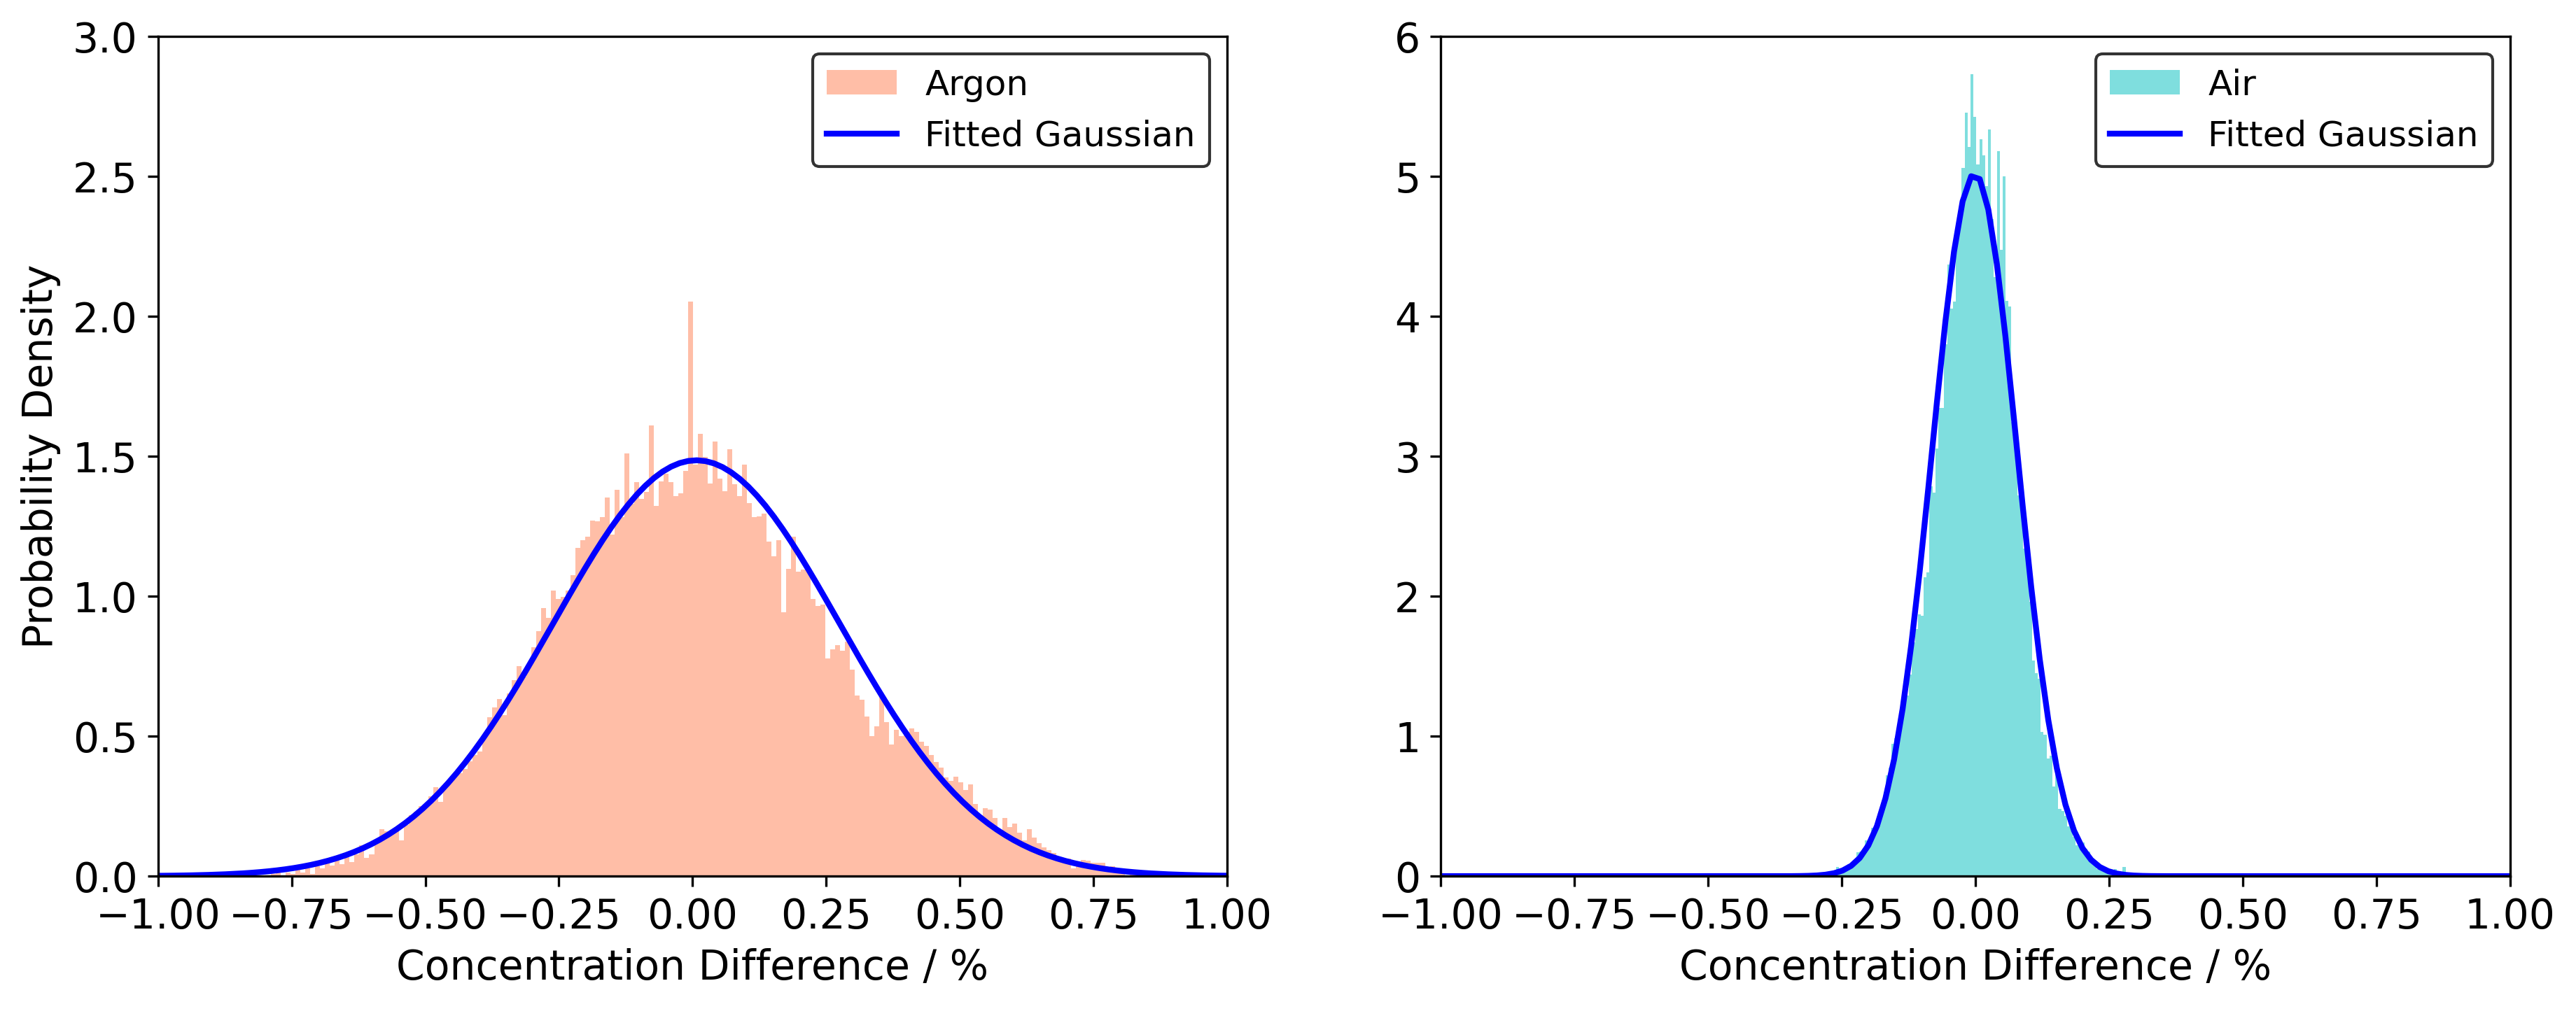

In [ ]:
from scipy.stats import norm

nr = 1
nc = 2

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,5*nr),dpi=300)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.4)
ax = ax.flatten()
kwargs = dict(alpha=0.5, bins=200)

for idx in range(nr*nc):
  if idx == 0:
    ax[idx].hist(diff_groundtruth[:,0], **kwargs,color = 'coral',label='Argon',density=True)
    ax[idx].set_ylabel('Probability Density', fontsize=14)
    mu, std = norm.fit(diff_groundtruth[:,0])
    x = np.linspace(-4,4, 500)
    p = norm.pdf(x, mu, std)
    ax[idx].plot(x, p, 'b', linewidth=2,label='Fitted Gaussian')

  else:
    ax[idx].hist(diff_groundtruth[:,1], **kwargs,color = 'c',label='Air',density=True)
    mu_1, std_1 = norm.fit(diff_groundtruth[:,1])
    x_1 = np.linspace(-4,4,500)
    p_1 = norm.pdf(x_1, mu_1, std_1)
    ax[idx].plot(x_1, p_1, 'b', linewidth=2,label='Fitted Gaussian')

  ax[idx].set_xlim(-1,1)
  ax[idx].set_xlabel('Concentration Difference / %', fontsize=14)
  ax[idx].legend(loc='upper right',edgecolor='k',fontsize=12,frameon=True,ncol=1)

ax[0].set_ylim(0,3)
ax[1].set_ylim(0,6)

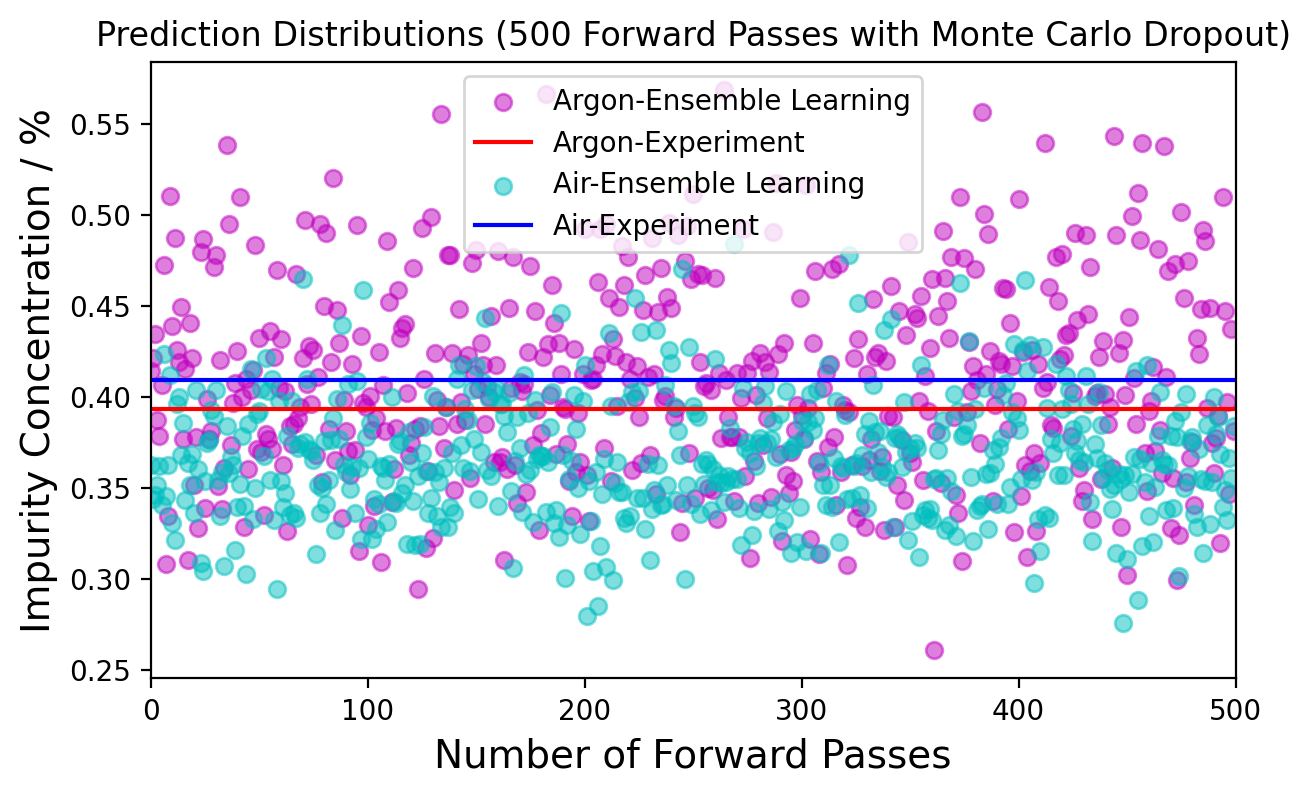

In [ ]:
plt.figure(figsize=(7, 4), dpi=200)

Wave_idx = 100
num_forward_passes = 500
test_wave = Response_test[Wave_idx:Wave_idx+1, :]
test_image = Image_test[Wave_idx:Wave_idx+1, :, :, :]

predictions = []
truth = Concen_test[Wave_idx:Wave_idx+1, :]

cnn.train()
cnn_stft.train()
ensemble_model.train()

inputs_test = torch.from_numpy(test_wave.reshape(test_wave.shape[0], 2, 426)).to(torch.float32).to(device)
inputs_test_image = torch.from_numpy(test_image).to(torch.float32).to(device).reshape(-1, 2, 20, 44)

for _ in range(num_forward_passes):
    test_prediction = ensemble_model(inputs_test, inputs_test_image).cpu().detach().numpy()
    predictions.append(test_prediction)

predictions = np.array(predictions).reshape(num_forward_passes, -1)
pre_mean = np.mean(predictions, axis=0)

# Scatter plot of predictions for Argon
plt.scatter(range(num_forward_passes), predictions[:, 0], color='m', alpha=0.5, label='Argon-Ensemble Learning')
# Solid line for Argon truth value
plt.axhline(y=truth[0, 0], color='r', linewidth=1.5, label='Argon-Experiment')

# Scatter plot of predictions for Air
plt.scatter(range(num_forward_passes), predictions[:, 1], color='c', alpha=0.5, label='Air-Ensemble Learning')
# Solid line for Air truth value
plt.axhline(y=truth[0, 1], color='b', linewidth=1.5, label='Air-Experiment')
plt.xlim(0,500)

plt.xlabel('Number of Forward Passes', fontsize=14)
plt.ylabel('Impurity Concentration / %', fontsize=14)
plt.title(f'Prediction Distributions ({num_forward_passes} Forward Passes with Monte Carlo Dropout)')
plt.legend()
plt.show()

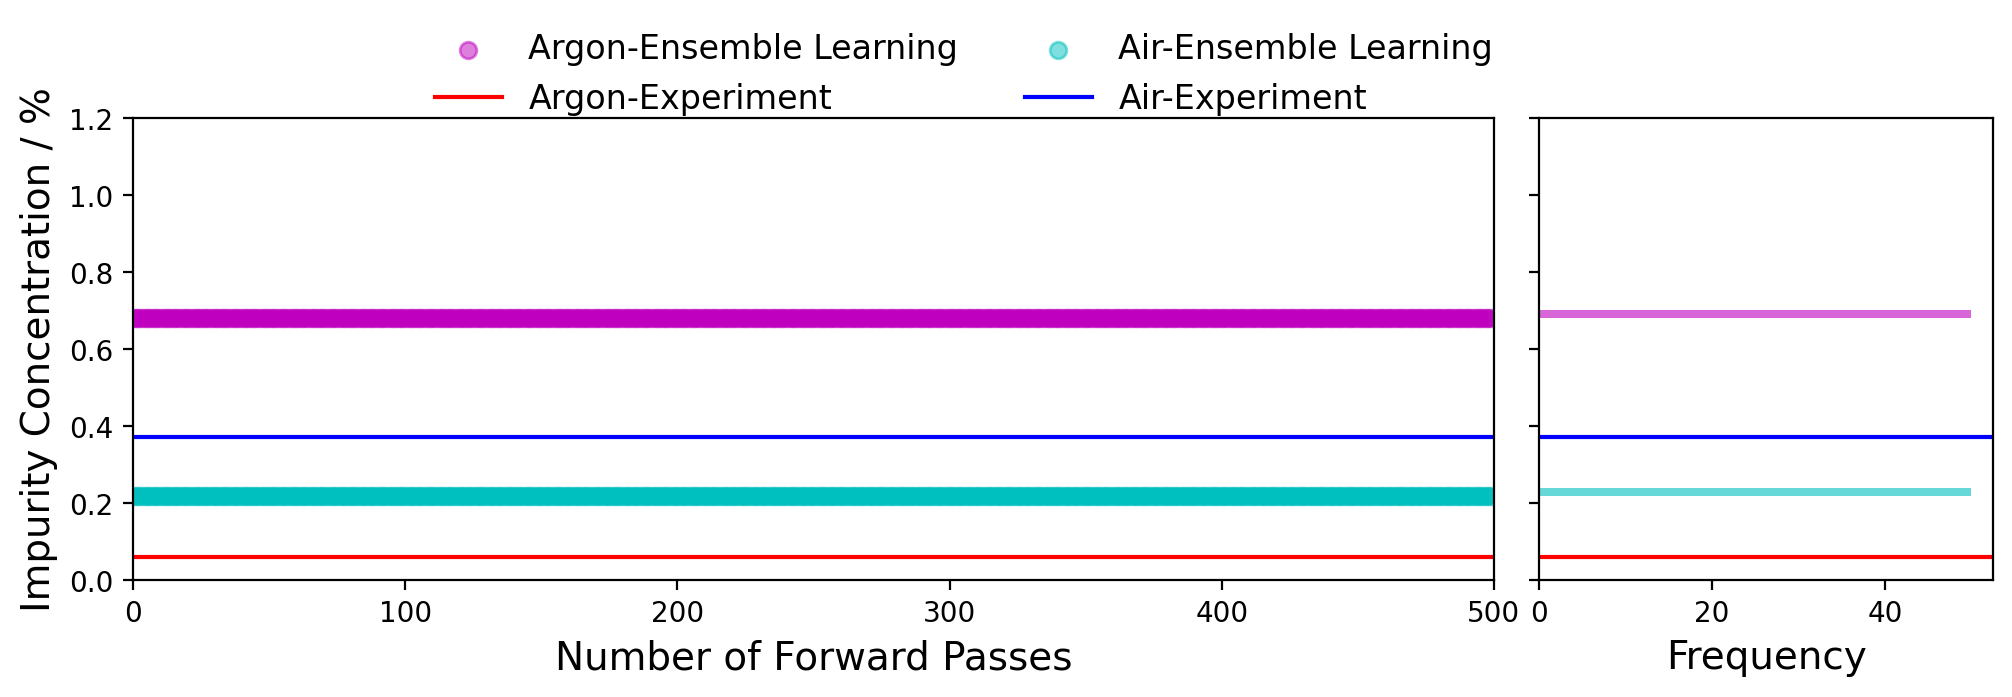

In [ ]:
Wave_idx = np.random.randint(Response_test.shape[0])
num_forward_passes = 500
test_wave = Response_test[Wave_idx:Wave_idx+1, :]
test_image = Image_test[Wave_idx:Wave_idx+1, :, :, :]

predictions = []
truth = Concen_test[Wave_idx:Wave_idx+1, :]

cnn.train()
cnn_stft.train()
ensemble_model.train()

inputs_test = torch.from_numpy(test_wave.reshape(test_wave.shape[0], 2, 426)).to(torch.float32).to(device)
inputs_test_image = torch.from_numpy(test_image).to(torch.float32).to(device).reshape(-1, 2, 38, 44)

for _ in range(num_forward_passes):
    test_prediction = ensemble_model(inputs_test, inputs_test_image).cpu().detach().numpy()
    predictions.append(test_prediction)

predictions = np.array(predictions).reshape(num_forward_passes, -1)
pre_mean = np.mean(predictions, axis=0)

fig = plt.figure(figsize=(12, 3), dpi=200)
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1],wspace=0.05)

# Scatter plot of predictions for Argon and Air
ax1 = plt.subplot(gs[0])
ax1.scatter(range(num_forward_passes), predictions[:, 0], color='m', alpha=0.5, label='Argon-Ensemble Learning')
ax1.axhline(y=truth[0, 0], color='r', linewidth=1.5, label='Argon-Experiment')
ax1.scatter(range(num_forward_passes), predictions[:, 1], color='c', alpha=0.5, label='Air-Ensemble Learning')
ax1.axhline(y=truth[0, 1], color='b', linewidth=1.5, label='Air-Experiment')
ax1.set_xlim(0, 500)
ax1.set_xlabel('Number of Forward Passes', fontsize=14)
ax1.set_ylabel('Impurity Concentration / %', fontsize=14)
ax1.set_ylim(0, 1.2)
ax1.legend(loc='upper left',edgecolor='b',fontsize='large',bbox_to_anchor=(0.2,1.25),frameon=False,ncol=2)

# Histogram of predictions for Argon and Air
ax2 = plt.subplot(gs[1])
ax2.hist(predictions[:, 0], bins=50, density=True, orientation='horizontal', color='m', alpha=0.6, label='Argon')
#ax2.axhline(y=pre_mean[0], color='g', linestyle='dashed', linewidth=1.5, label='Argon Mean')
ax2.axhline(y=truth[0, 0], color='r', linestyle='-', linewidth=1.5)
ax2.hist(predictions[:, 1], bins=50, density=True, orientation='horizontal', color='c', alpha=0.6, label='Air')
#ax2.axhline(y=pre_mean[1], color='g', linestyle='dashed', linewidth=1.5, label='Air Mean')
ax2.axhline(y=truth[0, 1], color='b', linestyle='-', linewidth=1.5)
ax2.set_xlabel('Frequency', fontsize=14)
ax2.set_ylim(0, 1.2)

#ax2.legend()
ax2.set_yticklabels([])

plt.show()

Prediction: [0.6978013  0.44315717]
Truth: [[0.8862898  0.37275572]]
Index in testing set: 4720
Prediction: [0.7323461  0.43717775]
Truth: [[0.59367619 0.43366264]]
Index in testing set: 12713
Prediction: [0.6563255  0.09263718]
Truth: [[1.00615766 0.05960558]]
Index in testing set: 19067


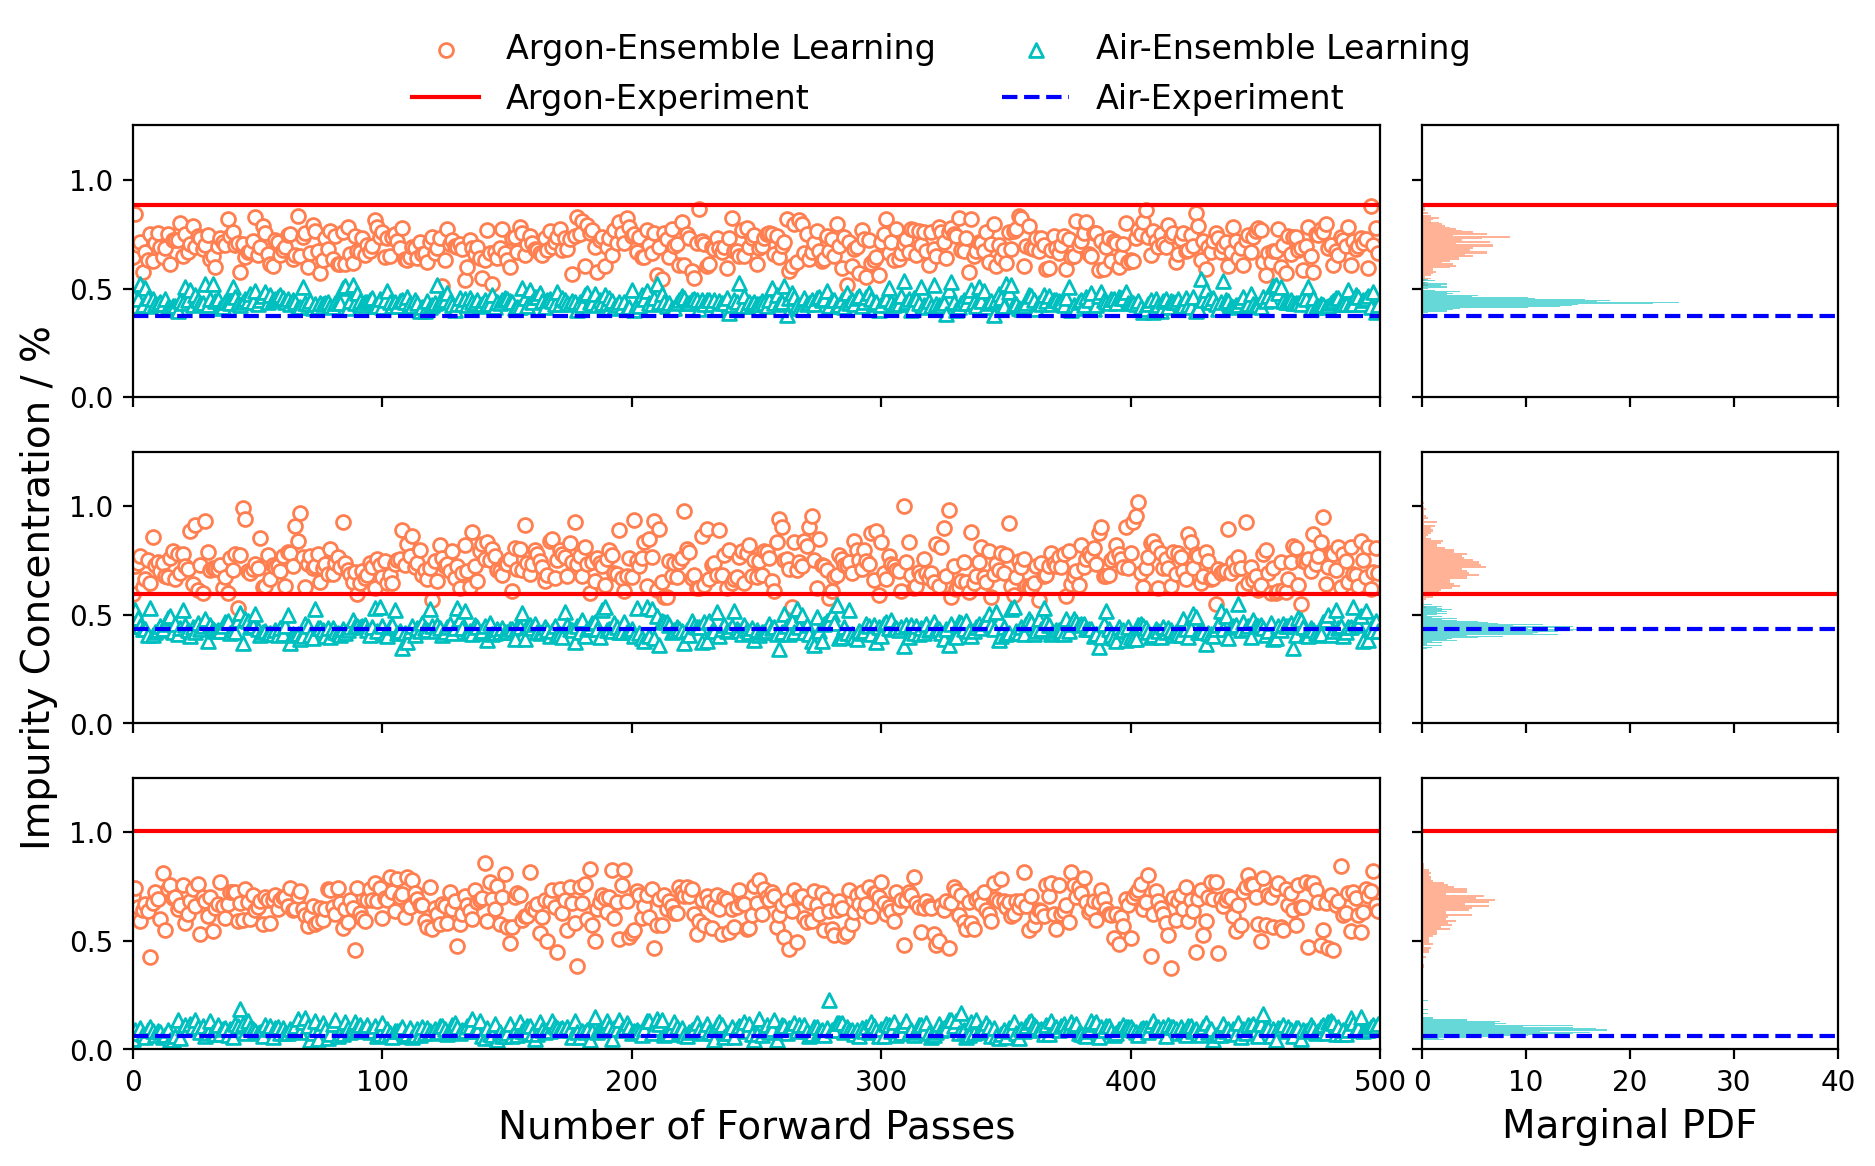

In [49]:
fig = plt.figure(figsize=(11, 6), dpi=200)
gs = gridspec.GridSpec(3, 2, width_ratios=[3, 1], wspace=0.05, hspace=0.2)

for i in range(3):
    Wave_idx = np.random.randint(Response_test.shape[0])
    num_forward_passes = 500
    test_wave = Response_test[Wave_idx:Wave_idx+1, :]
    test_image = Image_test[Wave_idx:Wave_idx+1, :, :, :]

    predictions = []
    truth = Concen_test[Wave_idx:Wave_idx+1, :]

    cnn.train()
    cnn_stft.train()
    ensemble_model.train()

    inputs_test = torch.from_numpy(test_wave.reshape(test_wave.shape[0], 2, 426)).to(torch.float32).to(device)
    inputs_test_image = torch.from_numpy(test_image).to(torch.float32).to(device).reshape(-1, 2, 38, 44)

    for _ in range(num_forward_passes):
        test_prediction = ensemble_model(inputs_test, inputs_test_image).cpu().detach().numpy()
        predictions.append(test_prediction)

    predictions = np.array(predictions).reshape(num_forward_passes, -1)
    pre_mean = np.mean(predictions, axis=0)

    print(f'Prediction: {pre_mean}')
    print(f'Truth: {truth}')
    print(f'Index in testing set: {Wave_idx}')

    # Scatter plot of predictions for Argon and Air
    ax1 = plt.subplot(gs[i * 2])
    ax1.scatter(range(num_forward_passes), predictions[:, 0], edgecolors='coral',facecolors='white',s=25,label='Argon-Ensemble Learning')
    ax1.axhline(y=truth[0, 0], color='r', linewidth=1.5, label='Argon-Experiment')
    ax1.scatter(range(num_forward_passes), predictions[:, 1],marker ='^', edgecolors='c',facecolors='white',s=25, label='Air-Ensemble Learning')
    ax1.axhline(y=truth[0, 1], color='b', linestyle='--',linewidth=1.5, label='Air-Experiment')
    ax1.set_xlim(0, 500)
    ax1.set_ylim(0, 1.25)

    if i == 0:
        ax1.legend(loc='upper left', edgecolor='b', fontsize='large', bbox_to_anchor=(0.2, 1.45), frameon=False, ncol=2)
    if i != 2:
        ax1.set_xticklabels([])

    if i == 2:
        ax1.set_xlabel('Number of Forward Passes', fontsize=14)
    if i == 1:
        ax1.set_ylabel('Impurity Concentration / %', fontsize=14)

    # Histogram of predictions for Argon and Air
    ax2 = plt.subplot(gs[i * 2 + 1])
    ax2.hist(predictions[:, 0], bins=50, density=True, orientation='horizontal', color='coral', alpha=0.6, label='Argon')
    ax2.axhline(y=truth[0, 0], color='r', linestyle='-', linewidth=1.5)
    ax2.hist(predictions[:, 1], bins=50, density=True, orientation='horizontal', color='c', alpha=0.6, label='Air')
    ax2.axhline(y=truth[0, 1], color='b', linestyle='--', linewidth=1.5)
    ax2.set_ylim(0, 1.25)
    ax2.set_xlim(0, 40)

    if i != 2:
        ax2.set_xticklabels([])

    if i == 2:
        ax2.set_xlabel('Marginal PDF', fontsize=14)

    ax2.set_yticklabels([])

plt.show()

Prediction: [0.8200559 0.5871265]
Truth: [[0.75371564 0.61509274]]
Index in testing set: 5249


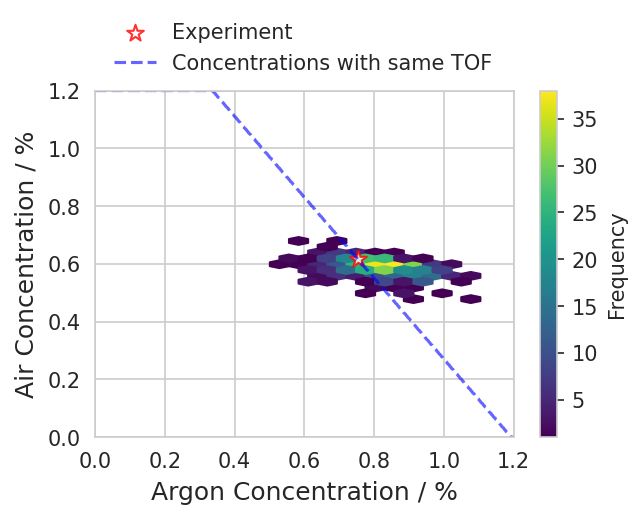

In [27]:
plt.figure(figsize=(4.5,3),dpi=150)  # Figure size

Wave_idx = np.random.randint(Response_test.shape[0])
num_forward_passes = 500
test_wave = Response_test[Wave_idx:Wave_idx+1, :]
test_image = Image_test[Wave_idx:Wave_idx+1, :, :, :]

predictions = []
truth = Concen_test[Wave_idx:Wave_idx+1, :]

cnn.train()
cnn_stft.train()
ensemble_model.train()

inputs_test = torch.from_numpy(test_wave.reshape(test_wave.shape[0], 2, 426)).to(torch.float32).to(device)
inputs_test_image = torch.from_numpy(test_image).to(torch.float32).to(device).reshape(-1, 2, 38, 44)

for _ in range(num_forward_passes):
    test_prediction = ensemble_model(inputs_test, inputs_test_image).cpu().detach().numpy()
    predictions.append(test_prediction)

predictions = np.array(predictions).reshape(num_forward_passes, -1)
pre_mean = np.mean(predictions, axis=0)

print(f'Prediction: {pre_mean}')
print(f'Truth: {truth}')
print(f'Index in testing set: {Wave_idx}')

# calculate the line
delta_TOF_truth = Cal_deltaTOF(truth[0, 0], truth[0, 1])
# Generate a range of con_argon values
con_argon_values = np.linspace(0, 1.2, 500)
# Find the corresponding con_air values
con_air_values = [find_closest_con_air(con_argon, delta_TOF_truth) for con_argon in con_argon_values]

# Hexbin plot
sns.set_style("whitegrid")

hb = plt.hexbin(predictions[:, 0], predictions[:, 1], gridsize=10, cmap='viridis', mincnt=1)
plt.scatter(truth[0, 0], truth[0, 1], marker='*',s=70, color='red',facecolors='white',alpha=0.8, label='Experiment')
plt.plot(con_argon_values, con_air_values, 'b--',alpha=0.6, label='Concentrations with same TOF')

plt.xlabel('Argon Concentration / %', fontsize=12)
plt.ylabel('Air Concentration / %', fontsize=12)
plt.xlim(0,1.2)
plt.ylim(0,1.2)
plt.legend(loc='upper left',edgecolor='b',fontsize='medium',bbox_to_anchor=(0,1.25),frameon=False,ncol=1)

cb = plt.colorbar(hb, label='Frequency')
plt.show()